# Imports

In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

# Random agents

## Pendulum-v1

Average reward: -1188.101093101385
Scores during testing


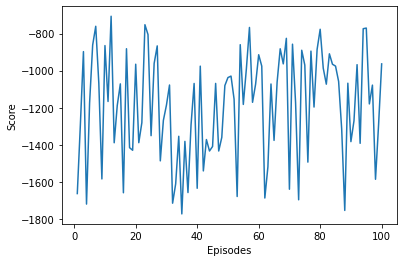

In [2]:
env = gym.make('Pendulum-v1')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## BipedalWalker-v3

Average reward: -98.95224474854993
Scores during testing


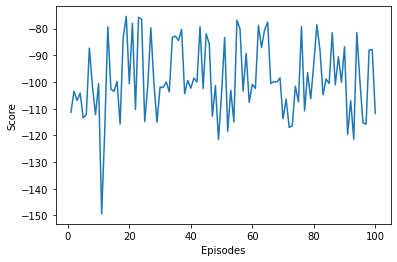

In [3]:
env = gym.make('BipedalWalker-v3')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## BipedalWalkerHardcore-v3

In [4]:
env = gym.make('BipedalWalkerHardcore-v3')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

KeyboardInterrupt: 

# Actor critic methods

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## DDPG

### Defining the DDPG agent

In [4]:
class DDPG_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, sigma,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.sigma = sigma
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        # Create actor network, critic network, their target copies, and their optimisers
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        # Create empty lists which will store transitions up to the capacity of the batch size
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        
        # At the start of each episode, reset the environment, score, step, and terminal
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            # If render is set to true, you can watch the agent learn each episode
            if self.render:
                env.render()
            
            # Use the action network to select an action
            # Sample noise from a normal distribution with mean 0 and standard deviation = sigma 
            # Add this noise to the selected action and take this action
            # Observe the outcome and update the episode's running total of the reward
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.sigma, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward
            
            # Store transitions in the memory lists
            # If the batch size is exceeded, replace the oldest transition in the memory list with the new one
            # Note that terminal = 1 if true so if the next state is terminal, 0 will be stored in terminal_memory 
            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward) 
                self.terminal_memory.append(1 - terminal)        
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1 
            
            # When there are more transitions stored than the batch size, randomly sample these transitions
            # Store each element of each sampled transition in these new lists 
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item])
                    terminals.append(self.terminal_memory[item])
                
                # Reformat sample lists 
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                
                # Calculate the actual next state Q values
                # Use this to calculate the actual current state Q values
                # Note that if the next state is terminal, the actual current state Q value will just be the reward
                target_actions = self.target_actor(next_states)
                next_Qtargets = self.target_critic(next_states, target_actions)
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Calculate the expected Q values 
                Qexpected = self.critic(states, actions)
                
                # Perform gradient descent on the critic network
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Perform gradient ascent on the actor network
                actions_predicted = self.actor(states)
                actor_loss = -self.critic(states, actions_predicted)
                actor_loss = torch.mean(actor_loss)
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update all target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))   
            
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    # Test the agent over 100 episodes 
    # Noise is not added to the action selected by the actor network during testing
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            scores.append(ep_reward)
        
        print('Mean score:', np.mean(scores))
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()
    
    # Visualise the agent over 10 episodes
    def visualise(self):
        for i in range(10):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

### Pendulum-v1

*************************************************************
Agent 1
Episode: 10 Score: -1173.512 	 Mean score over last 10 episodes: -1278.243
Episode: 20 Score: -1072.425 	 Mean score over last 10 episodes: -1194.412
Episode: 30 Score: -122.644 	 Mean score over last 10 episodes: -798.980
Episode: 40 Score: -117.164 	 Mean score over last 10 episodes: -328.473
Episode: 50 Score: -345.443 	 Mean score over last 10 episodes: -195.447
Episode: 60 Score: -349.744 	 Mean score over last 10 episodes: -211.755
Episode: 70 Score: -238.844 	 Mean score over last 10 episodes: -103.191
Episode: 80 Score: -120.662 	 Mean score over last 10 episodes: -241.324
Episode: 90 Score: -1391.700 	 Mean score over last 10 episodes: -335.054
Episode: 100 Score: -255.659 	 Mean score over last 10 episodes: -323.201
Episode: 110 Score: -233.196 	 Mean score over last 10 episodes: -226.181
Episode: 120 Score: -1.737 	 Mean score over last 10 episodes: -157.754
Episode: 130 Score: -122.274 	 Mean score over l

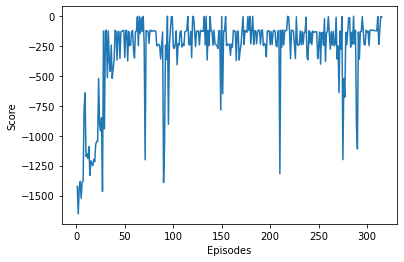

Agent 1 mean score of last 10 episodes during training


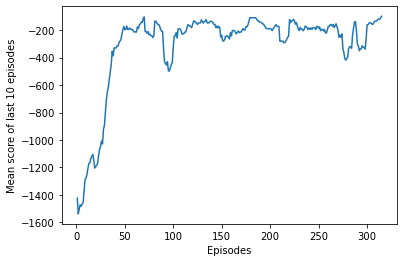

Agent 1 scores during testing
Mean score: -141.17793593246893


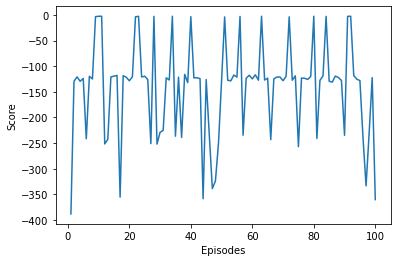

In [10]:
environment = 'Pendulum-v1' # Choose environment
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2 # Scale to the size of that environment's action space
    solved = -100 # No formal score to declare solved. Decided that solving requires a mean score of -100 over 10 episodes
elif environment == 'LunarLanderContinuous-v2':
    scaling = 1 
    solved = 200 # Solving requires a mean score of 200 over 100 episodes
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 # Solving requires a mean score of 300 over 100 episodes

previous = 10 # As solving requires the mean score over 10 episodes 
print_every = 10 # Print every 10 episodes
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))
    
    # Chosen hyperparameters chosen when creating our agent
    pendulum_DDPG = DDPG_Agent(scaling = scaling, render = False, buffer_size = 10000, batch_size = 64, gamma = 0.99, tau = 0.05, sigma = 0.1 * scaling,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.001, critic_lr = 0.01)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1
    
    # Keep training until the environment is solved or the number of episodes exceeds 3000
    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

        ep_reward = pendulum_DDPG.train()
        
        # Save the episode reward and the mean of the last 100 episodes
        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 
        
        # Print the score and mean of the last 10 episodes every 10 episodes
        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1
    
    # Print the mean agent score, the number of episodes ran, and the final mean of the last 10 episodes 
    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')
    
    # Plot the agent's score for each episode during training
    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()
    
    # Plot the agent's mean of the last 10 episodes for each episode during training
    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    # Plot the agent's score for each episode during testing
    print('Agent {} scores during testing'.format(i))
    pendulum_DDPG.test()

In [11]:
# DONE
pendulum_DDPG.visualise()

2022-05-04 12:25:48.514 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc724fac0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:48.515 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc758e410>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:48.521 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc758eb50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:48.523 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc753c510>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -127.2671564752191


2022-05-04 12:25:51.988 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7348810>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:51.988 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc72551d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:51.990 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7253410>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:51.992 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7252cd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -246.03327611608452


2022-05-04 12:25:55.532 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc76ff890>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:55.534 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7630220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:55.539 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc76309b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:55.542 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7631730>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -228.86097880918112


2022-05-04 12:25:58.984 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7598610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:58.985 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc75578d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:58.987 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7558060>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:25:58.988 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc758da50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -122.96480285214156


2022-05-04 12:26:02.412 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7449d40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:02.413 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7139320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:02.415 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7139940>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:02.417 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc71749c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -119.12146488293233


2022-05-04 12:26:05.828 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc725b880>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:05.828 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7265e70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:05.830 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7266600>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:05.832 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7255c50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -237.66337640442646


2022-05-04 12:26:09.210 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7341010>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:09.210 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc75421a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:09.212 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc740a5b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:09.214 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7420790>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -129.06567591235225


2022-05-04 12:26:12.610 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc74579e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:12.610 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7191170>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:12.612 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7177cd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:12.614 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7192550>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -3.520599685548003


2022-05-04 12:26:16.009 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc767b0f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:16.010 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7667150>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:16.012 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc76678e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:16.013 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc744ec10>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -121.15983281052544


2022-05-04 12:26:19.409 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc767cfd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:19.410 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7542b50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:19.412 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7546100>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 12:26:19.413 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7546bb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -125.50418114533751


### BipedalWalker-v3

*************************************************************
Agent 1
Episode: 100 Score: -111.096 	 Mean score over last 100 episodes: -113.901
Episode: 200 Score: -131.082 	 Mean score over last 100 episodes: -114.983
Episode: 300 Score: -143.123 	 Mean score over last 100 episodes: -130.699
Episode: 400 Score: -130.403 	 Mean score over last 100 episodes: -122.343
Episode: 500 Score: -116.795 	 Mean score over last 100 episodes: -113.950
Episode: 600 Score: 11.578 	 Mean score over last 100 episodes: -41.092
Episode: 700 Score: -96.423 	 Mean score over last 100 episodes: -55.875
Episode: 800 Score: -94.415 	 Mean score over last 100 episodes: -80.392
Episode: 900 Score: -20.417 	 Mean score over last 100 episodes: 19.952
Episode: 1000 Score: 36.902 	 Mean score over last 100 episodes: 51.684
Episode: 1100 Score: -60.786 	 Mean score over last 100 episodes: -16.595
Episode: 1200 Score: -144.339 	 Mean score over last 100 episodes: 21.446
Episode: 1300 Score: -150.571 	 Mean score ov

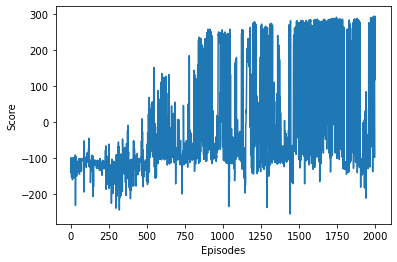

Agent 1 mean score of last 100 episodes during training


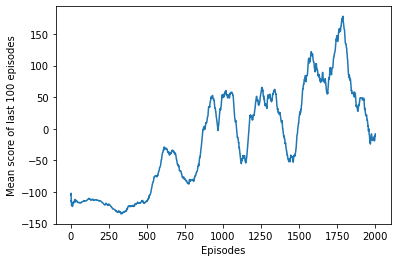

Agent 1 scores during testing
Mean score: 163.28420059340883


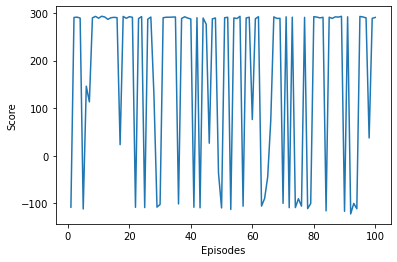

In [15]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment == 'LunarLanderContinuous-v2':
    scaling = 1
    solved = 200 
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    walker_DDPG = DDPG_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1 * scaling,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 1001:

        ep_reward = walker_DDPG.train()

        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    walker_DDPG.test()

In [ ]:
walker_DDPG.visualise()

In [ ]:
while (agent_moving_means[-1] < solved or episode <= previous) and episode < 2001:

    ep_reward = walker_TD3.train()

    if episode == 1: 
        agent_scores[0] = ep_reward
        agent_moving_means[0] = ep_reward
    else:
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 

    if episode % print_every == 0:
        print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

    episode += 1

episode -= 1
print('*********************************')
print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
print('*********************************')

x = [i for i in range(1, len(agent_scores) + 1)]
print('Agent {} scores during training'.format(i))
plt.plot(x, agent_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')              
plt.show()

x = [i for i in range(1, len(agent_moving_means) + 1)]
print('Agent {} mean score of last {} episodes during training'.format(i, previous))
plt.plot(x, agent_moving_means)
plt.ylabel('Mean score of last {} episodes'.format(previous))       
plt.xlabel('Episodes')
plt.show()

print('Agent {} scores during testing'.format(i))
walker_TD3.test()

In [ ]:
walker_DDPG.visualise()

## TD3

### Defining the agent

In [20]:
class TD3_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, sigma,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.sigma = sigma

        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        # Create actor network, 2 critic networks, their target copies, and their optimisers
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.critic2 = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.target_critic2 = copy.deepcopy(self.critic2)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_optimizer2 = torch.optim.Adam(self.critic2.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.sigma, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal)
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1    
            
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item]) 
                    terminals.append(self.terminal_memory[item])
                
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                    
                # Calculate policy noise then clip this noise
                # Add this policy noise to the actions that are selected by the actor network when given the next state
                target_actions = self.target_actor(next_states)
                actions_copy = copy.deepcopy(actions)
                noise = actions_copy.data.normal_(0, self.sigma * 2)
                noise = noise.clamp(-self.sigma * 5, self.sigma * 5)      
                target_actions = target_actions + noise
                
                # Calculate the actual next state Q values for each target critic network
                # Choose the smaller of these two next state q-values
                # Use this to calculate the value of actual current state Q value
                a = self.target_critic(next_states, target_actions)
                b = self.target_critic2(next_states, target_actions)
                next_Qtargets = torch.min(a,b) 
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Perform gradient descent on the first critic network             
                Qexpected = self.critic(states, actions)
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # Perform gradient descent on the second critic network       
                Qexpected2 = self.critic2(states, actions)
                critic_loss2 = nn.MSELoss()(Qexpected2, Qtargets)
                self.critic_optimizer2.zero_grad()
                critic_loss2.backward()
                self.critic_optimizer2.step()
                
                # Perform gradient ascent on the actor network every 2 steps
                if num_step % 2 == 0:
                    actions_predicted = self.actor(states)
                    actor_loss = -self.critic(states, actions_predicted)
                    actor_loss = torch.mean(actor_loss)
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()
                
                # Update all target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic2.parameters(), self.critic2.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau)) 
                
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))      
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            scores.append(ep_reward)
        
        print('Mean score:', np.mean(scores))
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()

    def visualise(self):
        for i in range(10):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

### BipedalWalker-v3

*************************************************************
Agent 1
Episode: 100 Score: -111.668 	 Mean score over last 100 episodes: -114.365
Episode: 200 Score: -101.206 	 Mean score over last 100 episodes: -115.429
Episode: 300 Score: -137.491 	 Mean score over last 100 episodes: -131.218
Episode: 400 Score: -96.469 	 Mean score over last 100 episodes: -110.754
Episode: 500 Score: -111.023 	 Mean score over last 100 episodes: -114.355
Episode: 600 Score: -101.886 	 Mean score over last 100 episodes: -83.697
Episode: 700 Score: -21.997 	 Mean score over last 100 episodes: -46.025
Episode: 800 Score: 235.040 	 Mean score over last 100 episodes: 93.915
Episode: 900 Score: 253.822 	 Mean score over last 100 episodes: 236.399
Episode: 1000 Score: 271.728 	 Mean score over last 100 episodes: 243.951
*********************************
Agent 1 complete 	 Mean score of agent: -14.158
BipedalWalker-v3 finished in 1000 episodes 	 Mean score over last 100 episodes: 243.951
********************

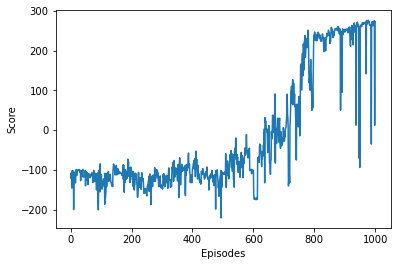

Agent 1 mean score of last 100 episodes during training


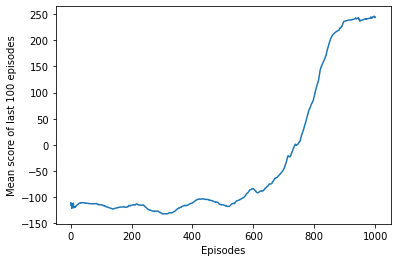

Agent 1 scores during testing
Mean score: 241.45468628211657


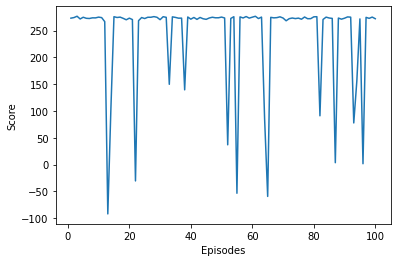

In [21]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment == 'LunarLanderContinuous-v2':
    scaling = 1
    solved = 200 
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    walker_TD3 = TD3_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1 * scaling,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 1001:

        ep_reward = walker_TD3.train()

        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    walker_TD3.test()

In [22]:
# 1000
walker_TD3.visualise()

2022-05-04 17:09:31.780 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3fc0320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:31.781 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd8224320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:31.784 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd82c8020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:31.786 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcf441a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 105.06969942465764


2022-05-04 17:09:39.622 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcff14b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:39.622 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd5896d20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:39.625 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd58fba60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:39.626 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3f92be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 275.91546602934784


2022-05-04 17:09:56.639 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcf46a20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:56.640 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdcf45c70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:56.642 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcf46400>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:09:56.644 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcf4f720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 272.99807787801404


2022-05-04 17:10:09.898 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd58efa20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:09.898 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3f602a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:09.901 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3fb64a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:09.903 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe14a2160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 273.57178463915716


2022-05-04 17:10:17.966 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3db3aa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:17.967 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe14bea80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:17.969 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe14e7ae0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:17.971 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe14c8610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 273.01823442458647


2022-05-04 17:10:27.612 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe147b360>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:27.612 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd503d6e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:27.615 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcbed3500>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:27.618 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd504c820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 272.05507843904076


2022-05-04 17:10:35.758 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd5826a90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:35.761 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fcbe19a80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:35.767 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcbe076e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:35.772 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcbe04a60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 276.3326146623481


2022-05-04 17:10:43.602 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd16117e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:43.605 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd503e7e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:43.611 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd50d9e90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:43.618 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd50139e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 275.96543330858725


2022-05-04 17:10:51.831 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd9fb53b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:51.831 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fee43f170>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:51.836 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fee4444a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:51.838 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe14ac640>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 274.67226741784623


2022-05-04 17:10:59.954 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd7aab070>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:59.954 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fddb8d420>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:59.957 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fddb878e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 17:10:59.962 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fddb858e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 270.4817820137583


Episode: 1000 Score: 269.056 	 Mean score over last 100 episodes: 244.139
Episode: 1100 Score: 278.486 	 Mean score over last 100 episodes: 263.933
Episode: 1200 Score: 274.600 	 Mean score over last 100 episodes: 243.818
Episode: 1300 Score: 287.189 	 Mean score over last 100 episodes: 257.187
Episode: 1400 Score: 282.835 	 Mean score over last 100 episodes: 266.498
Episode: 1500 Score: 288.113 	 Mean score over last 100 episodes: 278.801
Episode: 1600 Score: 283.898 	 Mean score over last 100 episodes: 280.255
Episode: 1700 Score: 292.144 	 Mean score over last 100 episodes: 279.105
Episode: 1800 Score: 282.804 	 Mean score over last 100 episodes: 257.881
Episode: 1900 Score: 293.873 	 Mean score over last 100 episodes: 282.783
Episode: 2000 Score: 293.574 	 Mean score over last 100 episodes: 288.987
*********************************
Agent 1 complete 	 Mean score of agent: 127.954
BipedalWalker-v3 finished in 2000 episodes 	 Mean score over last 100 episodes: 288.987
****************

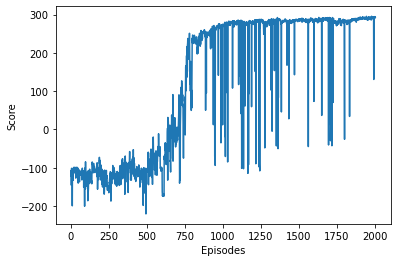

Agent 1 mean score of last 100 episodes during training


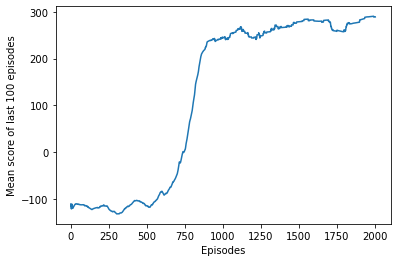

Agent 1 scores during testing
Mean score: 291.64445410830723


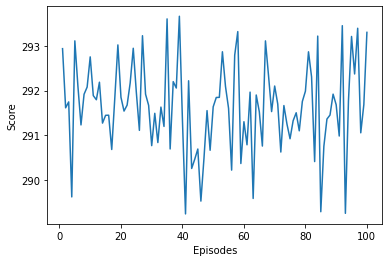

In [25]:
while (agent_moving_means[-1] < solved or episode <= previous) and episode < 2001:

    ep_reward = walker_TD3.train()

    if episode == 1: 
        agent_scores[0] = ep_reward
        agent_moving_means[0] = ep_reward
    else:
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 

    if episode % print_every == 0:
        print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

    episode += 1

episode -= 1
print('*********************************')
print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
print('*********************************')

x = [i for i in range(1, len(agent_scores) + 1)]
print('Agent {} scores during training'.format(i))
plt.plot(x, agent_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')              
plt.show()

x = [i for i in range(1, len(agent_moving_means) + 1)]
print('Agent {} mean score of last {} episodes during training'.format(i, previous))
plt.plot(x, agent_moving_means)
plt.ylabel('Mean score of last {} episodes'.format(previous))       
plt.xlabel('Episodes')
plt.show()

print('Agent {} scores during testing'.format(i))
walker_TD3.test()

In [26]:
walker_TD3.visualise()

2022-05-04 21:22:32.420 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe3726aa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:32.421 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdaae0020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:32.424 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb73c34e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:32.426 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8f06720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.38121525988583


2022-05-04 21:22:45.961 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd964f890>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:45.962 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe105f460>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:45.964 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe10452e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:45.966 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fef8ca920>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.81640288483084


2022-05-04 21:22:59.359 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd7a4a220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:59.359 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb8f4a020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:59.362 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8f5d720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:22:59.363 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb73d7d60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 292.1196322096424


2022-05-04 21:23:06.921 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdaa880a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:06.921 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdaaa05a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:06.924 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdaa8fda0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:06.925 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd49f5260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.5287135716043


2022-05-04 21:23:15.268 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8f545e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:15.270 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdaa82620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:15.273 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdaadad60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:15.277 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdaa8f1e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 292.176361929457


2022-05-04 21:23:22.737 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe342b6a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:22.738 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe1056e80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:22.741 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe1041d60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:22.745 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd7ae4ca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 292.0465744861601


2022-05-04 21:23:30.894 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd49dc5e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:30.895 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb8fc69a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:30.900 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8fe90e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:30.905 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8f8d4e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 292.47155086346976


2022-05-04 21:23:40.121 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd96c15e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:40.122 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdcf8e0e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:40.125 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcfcf220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:40.128 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc9fdea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.97216413931045


2022-05-04 21:23:51.227 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe342b950>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:51.228 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd9f82820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:51.232 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd9f82ad0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:23:51.235 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd9f76920>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.49910125753405


2022-05-04 21:24:01.491 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd967ff60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:24:01.491 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdc90b770>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:24:01.495 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc9083a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 21:24:01.504 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd96861a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 291.0787822018935


Episode: 2000 Score: 291.157 	 Mean score over last 100 episodes: 289.023
Episode: 2100 Score: 295.186 	 Mean score over last 100 episodes: 288.669
Episode: 2200 Score: 293.254 	 Mean score over last 100 episodes: 289.243
Episode: 2300 Score: 295.083 	 Mean score over last 100 episodes: 285.828
Episode: 2400 Score: 293.072 	 Mean score over last 100 episodes: 288.491
Episode: 2500 Score: 291.339 	 Mean score over last 100 episodes: 279.298
Episode: 2600 Score: 289.249 	 Mean score over last 100 episodes: 292.969
Episode: 2700 Score: 295.145 	 Mean score over last 100 episodes: 273.442
Episode: 2800 Score: 296.048 	 Mean score over last 100 episodes: 295.105
Episode: 2900 Score: 296.814 	 Mean score over last 100 episodes: 292.768
Episode: 3000 Score: 295.810 	 Mean score over last 100 episodes: 280.040
*********************************
Agent 1 complete 	 Mean score of agent: 180.850
BipedalWalker-v3 finished in 3000 episodes 	 Mean score over last 100 episodes: 280.040
****************

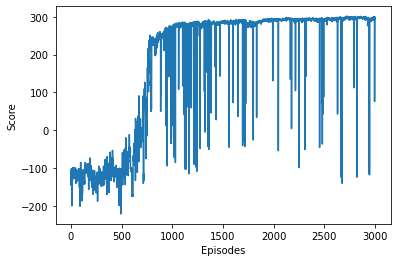

Agent 1 mean score of last 100 episodes during training


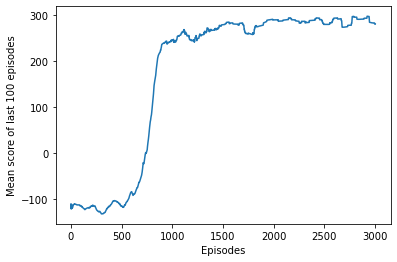

Agent 1 scores during testing
Mean score: 288.40671396633473


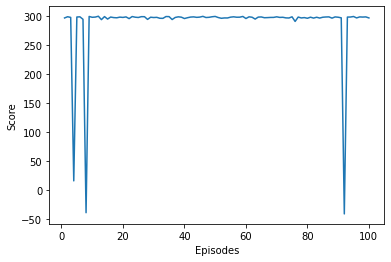

In [27]:
while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

    ep_reward = walker_TD3.train()

    if episode == 1: 
        agent_scores[0] = ep_reward
        agent_moving_means[0] = ep_reward
    else:
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 

    if episode % print_every == 0:
        print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

    episode += 1

episode -= 1
print('*********************************')
print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
print('*********************************')

x = [i for i in range(1, len(agent_scores) + 1)]
print('Agent {} scores during training'.format(i))
plt.plot(x, agent_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')              
plt.show()

x = [i for i in range(1, len(agent_moving_means) + 1)]
print('Agent {} mean score of last {} episodes during training'.format(i, previous))
plt.plot(x, agent_moving_means)
plt.ylabel('Mean score of last {} episodes'.format(previous))       
plt.xlabel('Episodes')
plt.show()

print('Agent {} scores during testing'.format(i))
walker_TD3.test()

In [28]:
walker_TD3.visualise()

2022-05-04 23:13:07.001 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc9411e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:07.002 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdc6c6320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:07.004 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d6b8e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:07.006 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcbe6a4a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 297.88814619358976


2022-05-04 23:13:19.309 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe149aca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:19.310 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdadb3420>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:19.312 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdada5560>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:19.314 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdadbf7e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 298.41786771836905


2022-05-04 23:13:31.877 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd823de20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:31.878 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb8d66820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:31.880 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdfeca1e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:31.882 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdfe52960>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -21.775970803448928


2022-05-04 23:13:36.624 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc97c4e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:36.624 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe4f0f4e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:36.626 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe4f10020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:36.628 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d9db80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 294.23587919012454


2022-05-04 23:13:49.557 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d3c3d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:49.557 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdcf9d280>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:49.560 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcfaca90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:13:49.562 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcfab060>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 297.992007279142


2022-05-04 23:14:02.231 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc99cdb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:02.234 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb8d098a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:02.241 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8da5d50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:02.246 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d6c160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 298.6551511555053


2022-05-04 23:14:14.943 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc95e150>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:14.943 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdcf9e160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:14.945 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd96de9a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:14.947 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d22520>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 298.8983048891658


2022-05-04 23:14:27.262 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdcf2dde0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:27.263 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3f8b550>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:27.265 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3fc5070>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:27.267 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3f7db60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 299.3027831519957


2022-05-04 23:14:39.747 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d29de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:39.749 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdad433e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:39.752 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdad86160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:39.754 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdad44b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 299.0072082550651


2022-05-04 23:14:52.199 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb8d948f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:52.202 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3d1dc20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:52.208 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3d06060>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:14:52.214 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdbc903a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -48.5344666230424


### BipedalWalkerHardcore-v3

##### Testing the last trained agent on BipedalWalkerHardcore-v3

Scores during testing
Mean score: -60.447052347783895


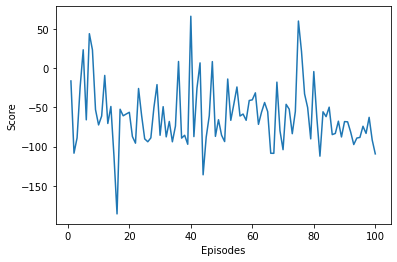

In [29]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        tensor_state = torch.from_numpy(state).float()
        action = walker_TD3.actor(tensor_state)
        action = action.detach().numpy()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state

    scores.append(ep_reward)

print('Scores during testing')
print('Mean score:', np.mean(scores))
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

In [30]:
walker_TD3.visualise()

2022-05-04 23:17:24.766 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdad70920>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:24.766 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3f3d3d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:24.768 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3f3d860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:24.770 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3f3c0a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -46.57169283771592


2022-05-04 23:17:26.800 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fddbe5860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:26.801 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdc989170>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:26.803 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc93ed80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:26.805 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc9297e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -71.28454802300386


2022-05-04 23:17:29.832 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3be360>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:29.833 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd497b720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:29.835 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd49d3ba0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:29.837 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd49b8de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 51.49371982968225


2022-05-04 23:17:39.844 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe3728290>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:39.844 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3db7ec0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:39.846 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3d6b610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:39.850 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc684ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -60.60102553741074


2022-05-04 23:17:42.895 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe1426e20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:42.896 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdd3dace0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:42.898 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3b91a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:42.900 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3fa0a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -39.08464244295029


2022-05-04 23:17:48.839 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdfe096a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:48.843 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fddf16340>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:48.851 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe141fef0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:48.856 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fddf11650>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -48.86633512291127


2022-05-04 23:17:52.566 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe14270d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:52.570 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc7294500>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:52.576 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc7284ed0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:17:52.583 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fddb32bd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -131.5796996114912


2022-05-04 23:18:00.866 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe12136e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:00.871 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb4415260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:00.880 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb4410ce0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:00.886 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb44170e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -93.7751949052893


2022-05-04 23:18:02.557 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdbc7c260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:02.557 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdbc619b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:02.559 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdbc5b6a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:02.561 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdbc5b950>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -30.075809499502213


2022-05-04 23:18:05.160 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd38df20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:05.160 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe1846f60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:05.162 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdbc61460>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-04 23:18:05.165 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe141fc30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -16.874972768401534


#### Continue training the most recent TD3 BipedalWalker-v3 agent on BipedalWalkerHardcore-v3

*************************************************************
Agent 1
Episode: 100 Score: -71.907 	 Mean score over last 100 episodes: -101.829
Episode: 200 Score: -16.303 	 Mean score over last 100 episodes: -83.432
Episode: 300 Score: -108.201 	 Mean score over last 100 episodes: -110.598
Episode: 400 Score: -143.942 	 Mean score over last 100 episodes: -126.235
Episode: 500 Score: -187.960 	 Mean score over last 100 episodes: -149.231
Episode: 600 Score: -156.820 	 Mean score over last 100 episodes: -172.214
Episode: 700 Score: -157.472 	 Mean score over last 100 episodes: -169.162
Episode: 800 Score: -167.027 	 Mean score over last 100 episodes: -192.172
Episode: 900 Score: -170.043 	 Mean score over last 100 episodes: -166.842
Episode: 1000 Score: -182.725 	 Mean score over last 100 episodes: -168.586
*********************************
Agent 1 complete 	 Mean score of agent: -144.030
BipedalWalkerHardcore-v3 finished in 1000 episodes 	 Mean score over last 100 episodes: -168.586
**

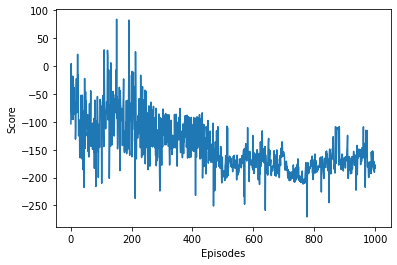

Agent 1 mean score of last 100 episodes during training


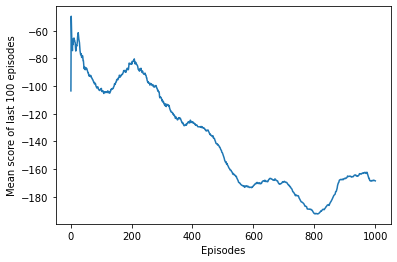

Scores during testing
Mean score: -173.76192924526433


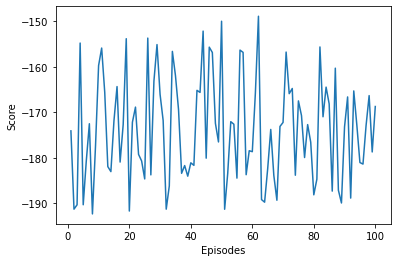

In [31]:
print('*************************************************************')
print('Agent 1')

hardcore_adapt_TD3 = copy.deepcopy(walker_TD3)

agent_scores = [0]
agent_moving_means = [0]
episode = 1

while (agent_moving_means[-1] < solved or episode <= previous) and episode < 1001:

    ep_reward = walker_TD3.train()

    if episode == 1: 
        agent_scores[0] = ep_reward
        agent_moving_means[0] = ep_reward
    else:
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 

    if episode % print_every == 0:
        print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

    episode += 1

episode -= 1
print('*********************************')
print('Agent 1 complete \t Mean score of agent: {:.3f}'.format(np.mean(agent_scores))) 
print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
print('*********************************')

x = [i for i in range(1, len(agent_scores) + 1)]
print('Agent 1 scores during training')
plt.plot(x, agent_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')              
plt.show()

x = [i for i in range(1, len(agent_moving_means) + 1)]
print('Agent 1 mean score of last {} episodes during training'.format(previous))
plt.plot(x, agent_moving_means)
plt.ylabel('Mean score of last {} episodes'.format(previous))       
plt.xlabel('Episodes')
plt.show()

print('Scores during testing')
walker_TD3.test()

In [32]:
walker_TD3.visualise()

2022-05-05 06:33:36.933 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd8213650>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:33:36.934 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd6d66de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:33:36.936 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d3be20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:33:36.938 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d1e220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -171.65240219232535


2022-05-05 06:34:05.213 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc69f160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:05.214 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdc6557e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:05.216 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc64b8e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:05.218 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d92be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -179.41422386140914


2022-05-05 06:34:40.361 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3c7070>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:40.362 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdd3f8a80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:40.364 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3cd540>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:34:40.366 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd39f620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -168.45441383032843


2022-05-05 06:35:15.500 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3aa090>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:15.500 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdd306f60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:15.503 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3efd60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:15.504 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdb9c3420>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -187.9435794545616


2022-05-05 06:35:34.523 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3f60550>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:34.524 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3f8ae30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:34.526 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3faf4a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:34.528 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3fec660>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -146.3514650045672


2022-05-05 06:35:51.553 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d8f6a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:51.554 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fe140e320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:51.556 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe143d7e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:35:51.558 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fe1437320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -157.79438266003353


2022-05-05 06:36:15.872 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdd3da2e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:15.873 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fdb92f8e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:15.875 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdb947da0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:15.877 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd1809bb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -185.41149714355407


2022-05-05 06:36:34.401 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3d890a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:34.401 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd3d799a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:34.404 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d8b7a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:34.406 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d2dea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -169.88113588946032


2022-05-05 06:36:57.727 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd6d19960>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:57.727 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd1805f00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:57.729 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcbe34160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:36:57.731 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdedbcb70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -169.8479594487605


2022-05-05 06:37:21.663 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd3d5ab60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:37:21.664 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fb73aad50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:37:21.666 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fb7333bc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:37:21.669 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdc6c5660>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -156.83798704423282


#### Training the agent on BipedalWalkerHardcore-v3 from scratch

*************************************************************
Agent 1
Episode: 100 Score: -116.347 	 Mean score over last 100 episodes: -112.936
Episode: 200 Score: -138.647 	 Mean score over last 100 episodes: -134.267
Episode: 300 Score: -168.422 	 Mean score over last 100 episodes: -140.044
Episode: 400 Score: -124.847 	 Mean score over last 100 episodes: -130.314
Episode: 500 Score: -72.356 	 Mean score over last 100 episodes: -126.183
Episode: 600 Score: -126.605 	 Mean score over last 100 episodes: -127.457
Episode: 700 Score: -131.880 	 Mean score over last 100 episodes: -134.853
Episode: 800 Score: -107.465 	 Mean score over last 100 episodes: -123.637
Episode: 900 Score: -126.179 	 Mean score over last 100 episodes: -124.810
Episode: 1000 Score: -104.517 	 Mean score over last 100 episodes: -129.632
*********************************
Agent 1 complete 	 Mean score of agent: -128.413
BipedalWalkerHardcore-v3 finished in 1000 episodes 	 Mean score over last 100 episodes: -129.632


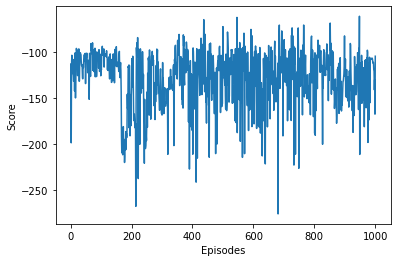

Agent 1 mean score of last 100 episodes during training


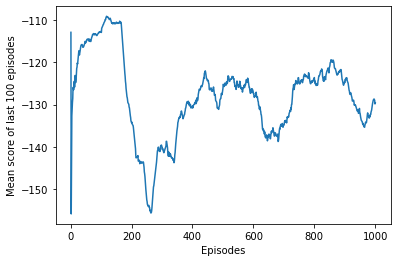

Agent 1 scores during testing
Mean score: -138.23778471999253


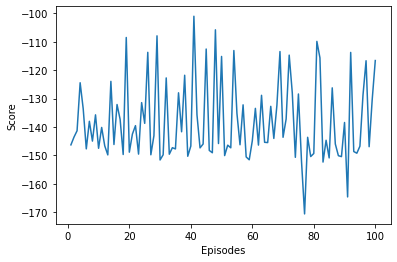

In [36]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment == 'LunarLanderContinuous-v2':
    scaling = 1
    solved = 200 
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    hardcore_TD3 = TD3_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1 * scaling,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 1001:

        ep_reward = hardcore_TD3.train()

        if episode == 1:
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    hardcore_TD3.test()

In [ ]:
hardcore_TD3.visualise()

2022-05-05 10:50:16.632 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcf2f1860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:16.633 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc23b23a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:16.637 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc233ba60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:16.640 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc2310720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -145.85484057155395


2022-05-05 10:50:55.626 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcf2c24a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:55.627 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fcf20a760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:55.632 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcf2fc1a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:50:55.636 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fcf23d320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -112.8060279593675


2022-05-05 10:51:37.403 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc21458d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:51:37.408 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc2355aa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:51:37.414 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc238def0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:51:37.418 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fa2892a60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -150.14990579148323


2022-05-05 10:52:19.350 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc2a5c0a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:52:19.351 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fc230f320>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:52:19.356 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc0d094f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:52:19.360 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc0d37ca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -128.92263830304617


2022-05-05 10:53:04.879 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fc2347020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:53:04.882 python[36287:1248035] Warning: Expected min height of view: (<NSButton: 0x7f8fd0504ca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:53:04.889 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fd05cd020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 10:53:04.897 python[36287:1248035] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8fdb10c620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
